# Академия MADE


#### План:
1. Общая схема
2. Подготовка данных
3. Построение модели `CRNN` (`Convolutional Recurrent Neural Network`)
4. Интерфейс и применение функции потерь `CTC Loss` (`Connectionist Temporal Classification`)
5. Обучение и результаты


#### Convolutional Recurrent Neural Network (CRNN)

Модель CRNN (не путайте с R-CNN - семейством детекторов) предназначена для перевода изображений в текстовый вид. Она устроена следующим образом (см.изображение выше):
1. Первый этап - извлечение признаков. Входное изображение пропускается через последовательность сверточных слоев (с активациями, пулингом, вот эти вот всем), в результате чего получается тензор признаков размера, например, `C x H x W`. Если рассматривать в отдельности каждый из срезов вдоль оси "ширины" (`W`, последняя размерность), то можно сказать, что у нас получилась последовательность длины `W`. Каждый из этих элементов соответствует определенной области на исходном изображении
2. Второй этап - предсказание вероятностей каждого из символов алфавита **для каждого элемента последовательности**. Полученная на первом шаге последовательность признаков пропускается через рекуррентную сеть, в результате чего на выходе образуется последовательность той же длины, что и на входе. Размер каждого элемента равен мощности алфавита + 1 (этот "+1" - символ `blank` для использования `CTC-Loss`).
3. Третий этап - либо декодирование ("транскрипция") полученных на предыдущем шаге распределений в итоговый текст (при инференсе), либо вычисление `CTC-Loss` между полученными распределениями и `ground-truth`-последовательностями.


### 2. Подготовка данных

In [36]:
!pip install editdistance

In [37]:
import os
import cv2
import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear,LSTM
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models
import pandas as pd
import editdistance
from nltk import edit_distance

np.random.seed(21)

Датасет представляет собой размеченные изображения автомобильных номеров РФ, собранных из интернета либо сгенерированных автоматически.
Формат данных = папка с изображениями + файл конфигурации, в котором в виде списка хранятся записи о тексте на каждом из изображений.

In [38]:
config_path = os.path.join("/kaggle/input/vk-made-ocr/train_labels.csv")
images_path = os.path.join("/kaggle/input/vk-made-ocr/train/train")
images_path_test = os.path.join("/kaggle/input/vk-made-ocr/test/test")
assert os.path.isfile(config_path)
assert os.path.isdir(images_path)

config = pd.read_csv(config_path)
df = pd.read_csv(config_path)

In [39]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 276000
First 3 items:
Id
Expected



**NB: используются буквы латинского алфавита, кириллицу, цифры и знаки препинания.**

In [40]:
abc_o = ''.join(list(set(''.join(df['Expected'].astype(str).tolist()))))  # this is our alphabet for predictions.

In [41]:
abc = 'зтяуцвчюлощсрёшамбжыьфъгхиейэдкнпabcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789 ' + \
'зтяуцвчюлощсрёшамбжыьфъгхиейэдкнпabcdefghijklmnopqrstuvwxyz'.upper()

In [42]:
def clean_data(text):
    if len(set(str(text))-set(abc)) > 0:
        return False
    return True

In [43]:
df = df[df['Expected'].isna() == False]
config = df[df['Expected'].apply(clean_data)]
config = df[df['Expected'].apply(lambda x: False if any([it for it in str(x) if it not in abc]) else True)]

In [44]:
def filter_data(config):
    """Filter config items keeping only ones with correct text.
    
    Args:
        - config: List of dicts, each dict having keys "file" and "text".
        
    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for i, item in tqdm.tqdm((config).iterrows()):
        text = item["Expected"]
        assert not any(set(str(text))-set(abc))
        assert text == text
        file_path = '/kaggle/input/vk-made-ocr/train/train/' + item["Id"]
        config_filtered.append({"file": file_path,
                                    "text": text})
    return config_filtered

In [45]:
config = filter_data(config)
print("Total items in data after filtering:", len(config))

268757it [00:20, 12809.44it/s]

Total items in data after filtering: 268757


Теперь переходим к созданию класса датасета. Что важно:
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение номера (фиксированного размера `HxWx3`).
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости `->` `transforms` должны работать со словарем!
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).
  

In [46]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = str(self.texts[item])
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        
        Args:
            - String of text.
            
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        seq = [self.alphabet.find(t) + 1 for t in str(text)] 
        
        return seq

В качестве трансформации будем использовать только ресайз к фиксированному размеру `(320, 64)`. 

* **TODO: Реализовать для класса `Resize` метод `__call__()`, который бы доставал из словаря `item` изображение, ресайзил к фиксированному размеру и клал обратно в словарь.**   

  *Не забудьте про интерполяцию ([stackoverflow](https://stackoverflow.com/questions/3112364/how-do-i-choose-an-image-interpolation-method-emgu-opencv)).*

In [47]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".
        
        Returns: 
            Dict with image resized to self.size.
        """
        
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR 
        if item["image"].shape[0] > 3*item["image"].shape[1]:
            item["image"] = cv2.rotate(item["image"], cv2.ROTATE_90_COUNTERCLOCKWISE)
        item["image"] = cv2.resize(item['image'], self.size, interpolation=interpolation)
        
        return item

In [48]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

dict_keys(['image', 'seq', 'seq_len', 'text'])
Image shape: (64, 320, 3)
Seq: [18, 10, 3, 17, 26] Seq_len: 5
Text: боями


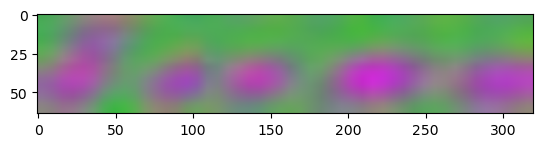

In [49]:
x = dataset[10]
print(x.keys())
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

---

In [50]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(str(item["text"]))
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [51]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [52]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])


Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([25])
Seq: tensor([118,   2,  20,  13,  16,   4,   2,  13,  16,  32,   1,  25,  10,  30,
          3,   2,  10,  11,   4,  11,  27,  32,  26,  28,  71],
       dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,']


### 3. Построение модели CRNN-like

Приступим к построению класса для модели нейросети.
Следуя описанию в начале этой страницы, вынесем (1) и (2) этапы пайплайна в отдельные компоненты модели (`self.cnn` и `self.rnn` соответственно).
Их можно реализовать практически независимо друг от друга, поэтому после занятия вы сможете самостоятельно поэкспериментировать со своими вариантами архитектур.

Начнем с построения `feature_extractor`. 

Для этого возьмем предобученную модель `ResNet18`, отрежем от нее последние два слоя (это `AdaptiveAvgPool2d` и `Linear`), оставив полносверточную часть. После всех сверточных слоев размер входного изображения уменьшается в 32 раза, а значит, входная картинка размером `64x320` превратится в тензор с высотой и шириной `2x10`. Для него мы сделаем пулинг по высоте (смотри параметры `self.pool`), превратив его в тензор размера `1x10`. 

Получим, что длина последовательности для подачи в `RNN` составляет всего лишь 10 (этого может быть мало для хорошей работы `CTC-Loss` с таргетами длины 8 или 9). Используем трюк (в методе `apply_projection`), применив сверточный слой с ядром (1x1) вдоль размерности ширины (а не глубины, как обычно), увеличив длину последовательности с 10 до `output_len`.

In [53]:
class FeatureExtractor(Module):
    
    def __init__(self, input_size=(64, 320), output_len=100):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features

In [54]:
feature_extractor = FeatureExtractor()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 100)

Итого, `FeaturesExtractor`:
- На вход получает тензор изображения размером `Bx3xHxW`
- На выходе отдает тензор признаков размером `Bx1xFxL`, где 
  - `F` - размерность вектора-токена (определяется числом признаков последнего сверточного слоя `ResNet18`, т.е. 512), 
  - `L` - "длина последовательности" токенов (`self.output_len`).

---

Теперь напишем класс для рекуррентной части пайплайна.

Будем использовать `GRU` (`bidirectional` или нет - выбор по параметру). Результат предсказаний после `GRU` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`. 

* **TODO: Реализовать метод `_init_hidden()` для инициализации скрытого состояния `GRU`.**

  *Про размерность `hidden_state` можно [посмотреть в документации](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU).*



`GRU` по умолчанию ожидает на вход тензор размера `L x B x F`, где `L` - длина последовательности, `B` - размер батча, `F` - размер одного элемента последовательности. 

* **TODO: Реализовать приведение тензора из `FeatureExtractor` к необходимому виду в функции `_reshape_features`.**

  *Пригодятся методы `torch.Tensor.squeeze()` и `torch.Tensor.permute()`.*

In [56]:
class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [57]:
sequence_predictor = SequencePredictor(input_size=512, 
                                       hidden_size=128, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [58]:
x = torch.randn(1, 1, 512, 20)
assert sequence_predictor._reshape_features(x).size() == (20, 1, 512)

In [59]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 162)

---

Теперь соберем две части в один класс CRNN.

In [60]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=100,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [61]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

Проверим, как все работает на случайном тензоре:

In [62]:
crnn = CRNN()
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (100, 1, 162)

In [63]:
decode(y, abc)

['fл;,0,/p;ТjшЫ8Сьf~jЁNЫЁjлD;ЁлT}dЫd8кьСкi*i}icXrd;цd;л;л,ТdZЙXp[p;ьfiNTi']

### 4. CTC-Loss

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

### 5. Обучение и результаты

In [64]:
ACTUALLY_TRAIN = True

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [65]:
crnn = CRNN()
params =sum(p.numel() for p in crnn.parameters() if p.requires_grad) 
f"{params // 1000000}_{params % 1000000 // 1000}_{params % 1000000 % 1000} parameters"


'11_544_110 parameters'

Зададим гиперпараметры обучения:

In [66]:
num_epochs = 15
batch_size = 128
num_workers = 4

In [67]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [68]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

Поделим данные на обучающую и валидационную выборки:

In [69]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]
nums = [''.join([str(l) for l in np.random.randint(1,9,5).tolist()]) for n in range(len(glob(f'{images_path_test}/*')))]
config_test_fake = [{'file':f,'text':n} for f,n in zip(glob(f'{images_path_test}/*'), nums)]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())
test_dataset_fake = RecognitionDataset(config_test_fake, transforms=Resize())

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

Запустим обучение (при параметрах по умолчанию эпоха занимает ~22 секунды на GPU):

In [70]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)
test_dataloader_fake = DataLoader(test_dataset_fake, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)


In [71]:
def char_error_rate(p_seq1, p_seq2):
    """
    params
    ---
    p_seq1 : str
    p_seq2 : str
    returns
    ---
    cer : float
    """
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    cer = editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / (max(len(c_seq1), len(c_seq2)) + 1e-9)
    return cer

In [72]:

ACTUALLY_TRAIN = True
def collate_fn_test(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    img_pth, images, seq_lens = [], [], []
    for item in batch:
        img_pth.append(str(item['img_path']))
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seq_lens.append(item["seq_len"])
    images = torch.stack(images)
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq_len": seq_lens, 'img_pth': img_pth}
    return batch

class RecognitionDataset4test(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, conf, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset4test, self).__init__()
        self.alphabet = alphabet
        self.image_names = conf.iloc[:,0]
        self.transforms = transforms

    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        path = self.image_names[item]
        image = cv2.imread(path).astype(np.float32) / 255.
        seq_len = self.__len__()
        output = dict(image=image, seq_len=seq_len, img_path=path)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

def get_submit(model, m_loss):
    files = glob(f'{images_path_test}/*')
    test_data = pd.DataFrame({'Id': files})#[:3]
    transforms = Resize(size=(320, 64))
    dataset_test = RecognitionDataset4test(test_data, alphabet=abc, transforms=transforms)
    test_dataloader = DataLoader(dataset_test, 
                                batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                                drop_last=False, collate_fn=collate_fn_test)
    image_id = []
    texts_ = []

    for i, b in enumerate(tqdm.tqdm(test_dataloader)):

        images = b["image"].to(device)
        iid =  b["img_pth"]


        with torch.no_grad():
            seqs_pred = model(images)

        preds = model(images.to(device)).cpu().detach()

        texts_pred = decode(preds, model.alphabet)
        texts_.extend(texts_pred)
        image_id.extend(iid)
    df_preds = pd.DataFrame({'Id': [f.split('/')[-1] for f in image_id], 'Predicted':texts_})
    df_preds.sort_values('Id').to_csv(f'submission_{np.round(m_loss,2)}.csv', index=False)

#         for j in range(3):
#             plt.figure(figsize=(15, 5))
#             pred_i = preds[:, j, :].T

#             plt.subplot(1, 2, 1)
#             image = images[j].permute(1, 2, 0).cpu().numpy()
#             plt.imshow(image)
#             plt.axis("off")
#             plt.title(texts_pred[j])
#             plt.show()
#         break

In [73]:
name_model = ''
if ACTUALLY_TRAIN:
    for epoch in range(num_epochs):
        crnn.train()
        epoch_losses = []
        errors = []
        werrors = []
        error_dist = []
        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]
            seqs_pred = crnn(images).cpu()

            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt.cpu(),  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt.cpu(),
                            zero_infinity=True)  # N
            text_preds = decode(seqs_pred, abc)
            
            size_chunk = len(text_preds)
            culc_error = sum([char_error_rate(b['text'][i], text_preds[i]) \
                        for i in range(size_chunk)])/(size_chunk + 1e-9)
            werror = sum([int(b['text'][i] != text_preds[i]) \
                        for i in range(size_chunk)])/(size_chunk + 1e-9)
            dist = sum([edit_distance(b['text'][i], text_preds[i]) \
                        for i in range(size_chunk)])/(size_chunk + 1e-9)
            errors.append(culc_error)
            epoch_losses.append(loss.item())
            werrors.append(werror)
            error_dist.append(dist)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(crnn.parameters(), 1.0)
            optimizer.step()
        mean_cer_train = np.round(np.mean(errors), 2)
        mean_loss = np.round(np.mean(epoch_losses), 2)
        mean_werrors = np.round(np.mean(werrors), 2)
        mean_error_dist = np.round(np.mean(error_dist), 2)
        print(f'Train info: epoch {epoch}, loss {mean_loss}, cer {mean_cer_train} wer {mean_werrors} livinstein {mean_error_dist}')

        crnn.eval()
        val_losses = []
        val_errors = []
        werrors_eval = []
        error_dist_eval = []
        for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            with torch.no_grad():
                seqs_pred = crnn(images.to(device))
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt.cpu(),  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt.cpu(),
                                zero_infinity=True)  # N
            
            preds = decode(seqs_pred, abc)
            size_chunk = len(preds)
            culc_error = sum([char_error_rate(b['text'][i], preds[i]) \
                        for i in range(size_chunk)])/(size_chunk + 1e-9)
            werror = sum([int(b['text'][i] != preds[i]) for i in range(size_chunk)])/(size_chunk + 1e-9)
            dist = sum([edit_distance(b['text'][i], preds[i]) for i in range(size_chunk)])/(size_chunk + 1e-9)
            val_errors.append(culc_error)
            val_losses.append(loss.item())
            werrors.append(werror)
            error_dist.append(dist)
        name_model = f'model_{loss}.pkl'
        torch.save(crnn.state_dict(), name_model)    
        mean_werrors_eval = np.round(np.mean(werrors), 2)
        mean_cer_eval = np.round(np.mean(val_errors), 2)
        mean_loss_eval = np.round(np.mean(val_losses), 2)
        mean_error_dist_eval = np.round(np.mean(error_dist), 2)
        print(f'Validation info: epoch {epoch}, loss {mean_loss_eval}, cer {mean_cer_eval} wer {mean_werrors} levinstein {mean_error_dist_eval}')
#         model = CRNN()
#         model.load_state_dict(torch.load(name_model))
#         model.to(device)
#         model.eval()
        get_submit(crnn, mean_loss_eval)
        


  0%|          | 5/1679 [00:49<4:38:26,  9.98s/it]


KeyboardInterrupt: 

In [ ]:
if ACTUALLY_TRAIN:
    y_ticks = ["-"] + [x for x in abc]

    images = b["image"]
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]
    texts = b["text"]

    preds = crnn(images.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)

    for i in range(3,10):
        plt.figure(figsize=(15, 5))
        pred_i = preds[:, i, :].T

        plt.subplot(1, 2, 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis("off")
        plt.title(texts_pred[i])

        plt.subplot(1, 2, 2)
#         plt.yticks(range(pred_i.size(0)), y_ticks)
        plt.imshow(pred_i)
#         plt.title(texts_pred[i])

        plt.show()
# else:
#     for i in range(1, 11):
        
#         image_val_log = cv2.imread(f"/kaggle/working/{str(i).zfill(2)}.png")
#         plt.figure(figsize=(15, 8))
#         plt.imshow(image_val_log[:, :, ::-1], interpolation="none")
#         plt.axis("off")
#         plt.show()